# Visualize spatial distribution of Wages in Indonesia

In [1]:
import geopandas as gpd
from geopandas import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from shapely.geometry import Point

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Read in the Data Frame from Stata files and Clean the Dataframes

In [2]:
#IPUMS Wage data
Path_IPUMS = ("/Users/idiosyncrasy58/Dropbox/Documents/College/"+
              "Universitat Autonoma de Barcelona/IDEA - Economics/"+
              "Doctoral Thesis Ideas/Migration/IFLS/Project Files/"+
              "IPUMS/Project Files/Census Wage Data.dta")

#IFLS Wage and Schooling data by Province
Path_IFLS = ("/Users/idiosyncrasy58/Dropbox/Documents/College/"+
             "Universitat Autonoma de Barcelona/IDEA - Economics/"+
             "Doctoral Thesis Ideas/Migration/IFLS/Project Files/")

#Master Path
Master_path = ("/Users/idiosyncrasy58/Dropbox/Documents/College/"+
               "Universitat Autonoma de Barcelona/IDEA - Economics/"+
               "Doctoral Thesis Ideas/Migration/IFLS/Project Files/Maps/"+
               "Python Visualization of Indonesian Statistics/Visualizations/"+
               "Creation of Shape Files and Visualizations/"+
               "Shape Files with Indonesian BPS Codes" )

#ONET ability score
ONET_path = ("/Users/idiosyncrasy58/Dropbox/Documents/College/"+
             "Universitat Autonoma de Barcelona/IDEA - Economics/"+
             "Doctoral Thesis Ideas/Migration/IFLS/Project Files/"+
             "Temp Files/Occ Codes Ability Level.dta")

#SQL Database for geocodes path
path_DB = ('/Users/idiosyncrasy58/Dropbox/Documents/College/'+
           'Universitat Autonoma de Barcelona/IDEA - Economics/'+
           'Doctoral Thesis Ideas/Migration/IFLS/Project Files/'+
           'Maps/Python Visualization of Indonesian Statistics/'+
           'Final_Databases/Database/indonesian_locations_with_geocodes.sqlite')

#Excel file with the Gross Regional Product
path_GRP = ('/Users/idiosyncrasy58/Dropbox/Documents/College/'+
            'Universitat Autonoma de Barcelona/IDEA - Economics/'+
            'Doctoral Thesis Ideas/Migration/IFLS/Project Files/'+
            'Descriptive Stats/Correlation between GRP per Cap and Med Wages.xlsx')

replace_dict = {'Prov Code':{82:81,94:91,36:32,21:14,75:71,19:16,74:73,76:73}}

island_dict = {
    'Island':{
        x:y for x in range(11,95) for y in range (1,10) if x//10==y
        }}

market_dict_1 ={
    'Market':{
        1:2,5:2,6:2,7:2,8:2,9:2
    }
}

market_dict_2 ={
    'Market':{3:1}
}

ONET = (pd.read_stata(ONET_path, convert_categoricals=False))

### IPUMS

In [3]:
#Read in the Data frame from Stata and clean: IPUMS Census Data

cols_keep = ["year", "r_wage_hr", "provmov", "MaxSchYrs", "age", "occ2"]

Census_Data = ( pd.read_stata(Path_IPUMS, convert_categoricals=False)[cols_keep] 
                  .rename(columns={'provmov':'Prov Code'})
                  .reset_index()
                  .rename(columns={'index':'serial'})
                  .replace(replace_dict, inplace=False)
                  .merge(ONET, how='left', on=["occ2"])
                  .drop("occ2", axis=1, inplace=False) )

#Recatogorize MaxSchYrs to 13 if it is greater than 12 years (at least some college)
Census_Data.ix[Census_Data["MaxSchYrs"]>12.0,"MaxSchYrs"]=13.0

#Create the Island Codes
Census_Data["Island"] = Census_Data["Prov Code"]
Census_Data.replace(island_dict, inplace=True)

#Create the Market Codes
Census_Data["Market"] = Census_Data["Island"]
Census_Data.replace(market_dict_1, inplace=True)
Census_Data.replace(market_dict_2, inplace=True)

#Change age to int
Census_Data = Census_Data[np.isfinite(Census_Data["age"])]
Census_Data["age"] = Census_Data["age"].astype('int8')

#Seperate the Children
Census_Data_Child = Census_Data[(Census_Data.age<15) & (Census_Data["Prov Code"]!=54)]

#Drop if year is not 1995, if age is less than 15 years old, and drop age column
Census_Data = ( Census_Data
                .loc[(Census_Data.year!=1976) & (Census_Data.age>=15)]
                .drop('age', axis=1, inplace=False) )

### IFLS

#### Wages of Individuals: Adults

In [4]:
cols_keep = ["year", "pidlink2", "r_wage_hr","occ2","age","provmov","MaxSchYrs"]
col_rename = {'pidlink2':'serial',"provmov":"Prov Code"}

Wages = ( pd.read_stata(Path_IFLS+"Temp Files/Wage Database1.dta", convert_categoricals=False)[cols_keep]
            .rename(columns=col_rename)
            .replace(replace_dict, inplace=False)
            .merge(ONET, how='left', on=["occ2"])
            .drop("occ2", axis=1, inplace=False)  )

#Create the Island Groupings
Wages["Island"] = Wages["Prov Code"]
Wages.replace(island_dict, inplace=True)

#Create the Market Codes
Wages["Market"] = Wages["Island"]
Wages.replace(market_dict_1, inplace=True)
Wages.replace(market_dict_2, inplace=True)

#Keep only those who are below the age of 15 - defined as children in all surveys and drop missing wages
Wages_Child = Wages[Wages.age<15]

#Remove children from the Adult Wages dataset and drop age and provmov columns and all missing wages
Wages = Wages.loc[Wages.age>=15].drop(["age"], axis=1, inplace=False)

### IFLS-East Wave

#### Tracker File of individuals

In [5]:
cols_keep = ["pidlink2", "MaxSchYrs", "flag_LastWave", "provmov", "wave"]
col_rename = {'pidlink2':'serial', 'provmov':'Prov Code', 'wave':'year'}

Tracker = ( pd.read_stata(Path_IFLS+"MasterTrack2.dta", convert_categoricals=False)[cols_keep]
              .rename(columns=col_rename)
              .replace(replace_dict, inplace=False))

#Keep only last wave and the year of 2012 for merging with IFLS-East
Tracker = Tracker.loc[(Tracker["flag_LastWave"]==1) & (Tracker.year==2012)]

#Drop the flag variables 
Tracker.drop(["flag_LastWave"], axis=1, inplace=True)

#Create the Island codes
Tracker["Island"] = Tracker["Prov Code"]
Tracker.replace(island_dict, inplace=True)

#Create the Market Codes
Tracker["Market"] = Tracker["Island"]
Tracker.replace(market_dict_1, inplace=True)
Tracker.replace(market_dict_2, inplace=True)

Read in the IFLS East wage data set to update values in Tracker data

In [6]:
cols_keep = ["pidlink2", "r_wage_hr"]

Wages_2012 = ( pd.read_stata(Path_IFLS+"Temp Files/2012 Wage Current.dta")[cols_keep]
                 .rename(columns=col_rename)
                 .replace(replace_dict, inplace=False)
                 .merge(Tracker, how='left',
                       on="serial", copy=False) )

del Tracker

Update the Wages by appending the 2012 dataset

In [7]:
Wages = Wages.append(Wages_2012, ignore_index=True)
del Wages_2012

#### Append IPUMS File

Append the IPUMS file and then generate the log hourly wages (erasing the real wages)

In [8]:
Wages = Wages.reset_index().append(Census_Data,ignore_index=True)

#Remove East-Timur
Wages = Wages[Wages["Prov Code"]!=54]

Wages = Wages[Wages.r_wage_hr<100]

#Drop the Cesnus_Data frame
del Census_Data

In [9]:
Wages["ln_wage_hr"]=np.log(Wages["r_wage_hr"])
Wages.drop("r_wage_hr",axis=1,inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [10]:
Wages["Skill_Level_School"] = (Wages.MaxSchYrs>=9).astype('int')
#Wages["Skill_Level_School_12"] = (Wages.MaxSchYrs>=12).astype('int')

## Generate the Provincial Median Wages and the Average Schooling Years

In [11]:
#Define dictionary with functions to apply
function = {'MaxSchYrs':'mean','ln_wage_hr':'median','serial':'count'}

Avg_Prov = Wages.groupby(["Prov Code","Skill_Level_School"], as_index=False).agg(function)

In [12]:
Avg_Prov["r_wage_hr"] = np.exp(Avg_Prov["ln_wage_hr"])

In [13]:
Avg_Prov = Avg_Prov[Avg_Prov.serial>2].drop(["serial","ln_wage_hr"], axis=1, inplace=False)

In [14]:
Avg_Prov

,Prov Code,Skill_Level_School,MaxSchYrs,r_wage_hr
0,11.0,0,4.826456,1.536895
1,11.0,1,11.673853,2.751231
2,12.0,0,4.526431,1.176195
3,12.0,1,11.298680,1.944994
4,13.0,0,4.501290,1.164906
5,13.0,1,11.526655,2.240502
6,14.0,0,5.109465,1.707661
7,14.0,1,11.536628,2.786292
8,15.0,0,4.815484,1.600932
9,15.0,1,11.382668,2.476596


## Generate the Island Median Wages and the Average Schooling Years

In [15]:
Avg_Island = Wages.groupby(["Island", "Skill_Level_School"], as_index=False).agg(function)

In [16]:
Avg_Island["r_wage_hr"] = np.exp(Avg_Island["ln_wage_hr"])
Avg_Island.drop(["ln_wage_hr","serial"],axis=1,inplace=True)

In [17]:
Avg_Island

,Island,Skill_Level_School,MaxSchYrs,r_wage_hr
0,1.0,0,4.338226,1.058575
1,1.0,1,11.375430,2.134576
2,3.0,0,3.998763,0.887151
3,3.0,1,11.442014,2.134576
4,5.0,0,3.146737,0.764454
5,5.0,1,11.646661,1.979389
6,6.0,0,3.602232,1.057582
7,6.0,1,11.532443,1.988225
8,7.0,0,3.407438,0.711395
9,7.0,1,11.574927,1.680248


## Generate the Market Median Wages and the Average Schooling Years
A "market" is reduced to the island of Java, where approximately 50% of the population lives. The rest of indonesia is then categorized as the second "market". 

In [18]:
function = {'MaxSchYrs':'mean','ln_wage_hr':'median'}

Avg_Market = Wages.groupby(["Market","Skill_Level_School"], as_index=False).agg(function)
#Avg_Market_12 = Wages.groupby(["Market","Skill_Level_School_12"], as_index=False).agg(function)

In [19]:
Avg_Market["r_wage_hr"] = np.exp(Avg_Market["ln_wage_hr"])
Avg_Market.drop(["ln_wage_hr"],axis=1,inplace=True)

In [20]:
Avg_Market

,Market,Skill_Level_School,MaxSchYrs,r_wage_hr
0,1.0,0,3.998763,0.887151
1,1.0,1,11.442014,2.134576
2,2.0,0,3.808471,0.935501
3,2.0,1,11.470837,2.070878


## Import Shape Files

In [21]:
Ind = ( GeoDataFrame.from_file(Master_path+"/Prov_merge/Prov_merge.shp")
                         .replace(replace_dict, inplace=False) )
Ind["Island"] = Ind["Prov Code"]
Ind.replace(island_dict, inplace=True)
Ind["Market"] = Ind["Island"]
Ind.replace(market_dict_1, inplace=True)
Ind.replace(market_dict_2, inplace=True)

### Merge the statistical information into the Geopandas Dataframes

In [22]:
Ind_Adult_Prov = Ind.merge(Avg_Prov, how='left', on="Prov Code")
Ind_Adult_Island = Ind.merge(Avg_Island, how='left', on="Island")
Ind_Adult_Market = Ind.merge(Avg_Market, how='left', on="Market").dropna()

In [23]:
#Fix Missing Values for wages on provinces that merge into 1993 provinces

Ind_Adult_Prov.ix[(Ind_Adult_Prov["Prov Code"]==72) & (Ind_Adult_Prov.Skill_Level_School==1),"r_wage_hr"]=2.114752
Ind_Adult_Prov.ix[(Ind_Adult_Prov["Prov Code"]==62) & (Ind_Adult_Prov.Skill_Level_School==1),"r_wage_hr"]=2.256190

## Plot the Chloropleths

### Wages by Different Aggregations - High and Low Skilled

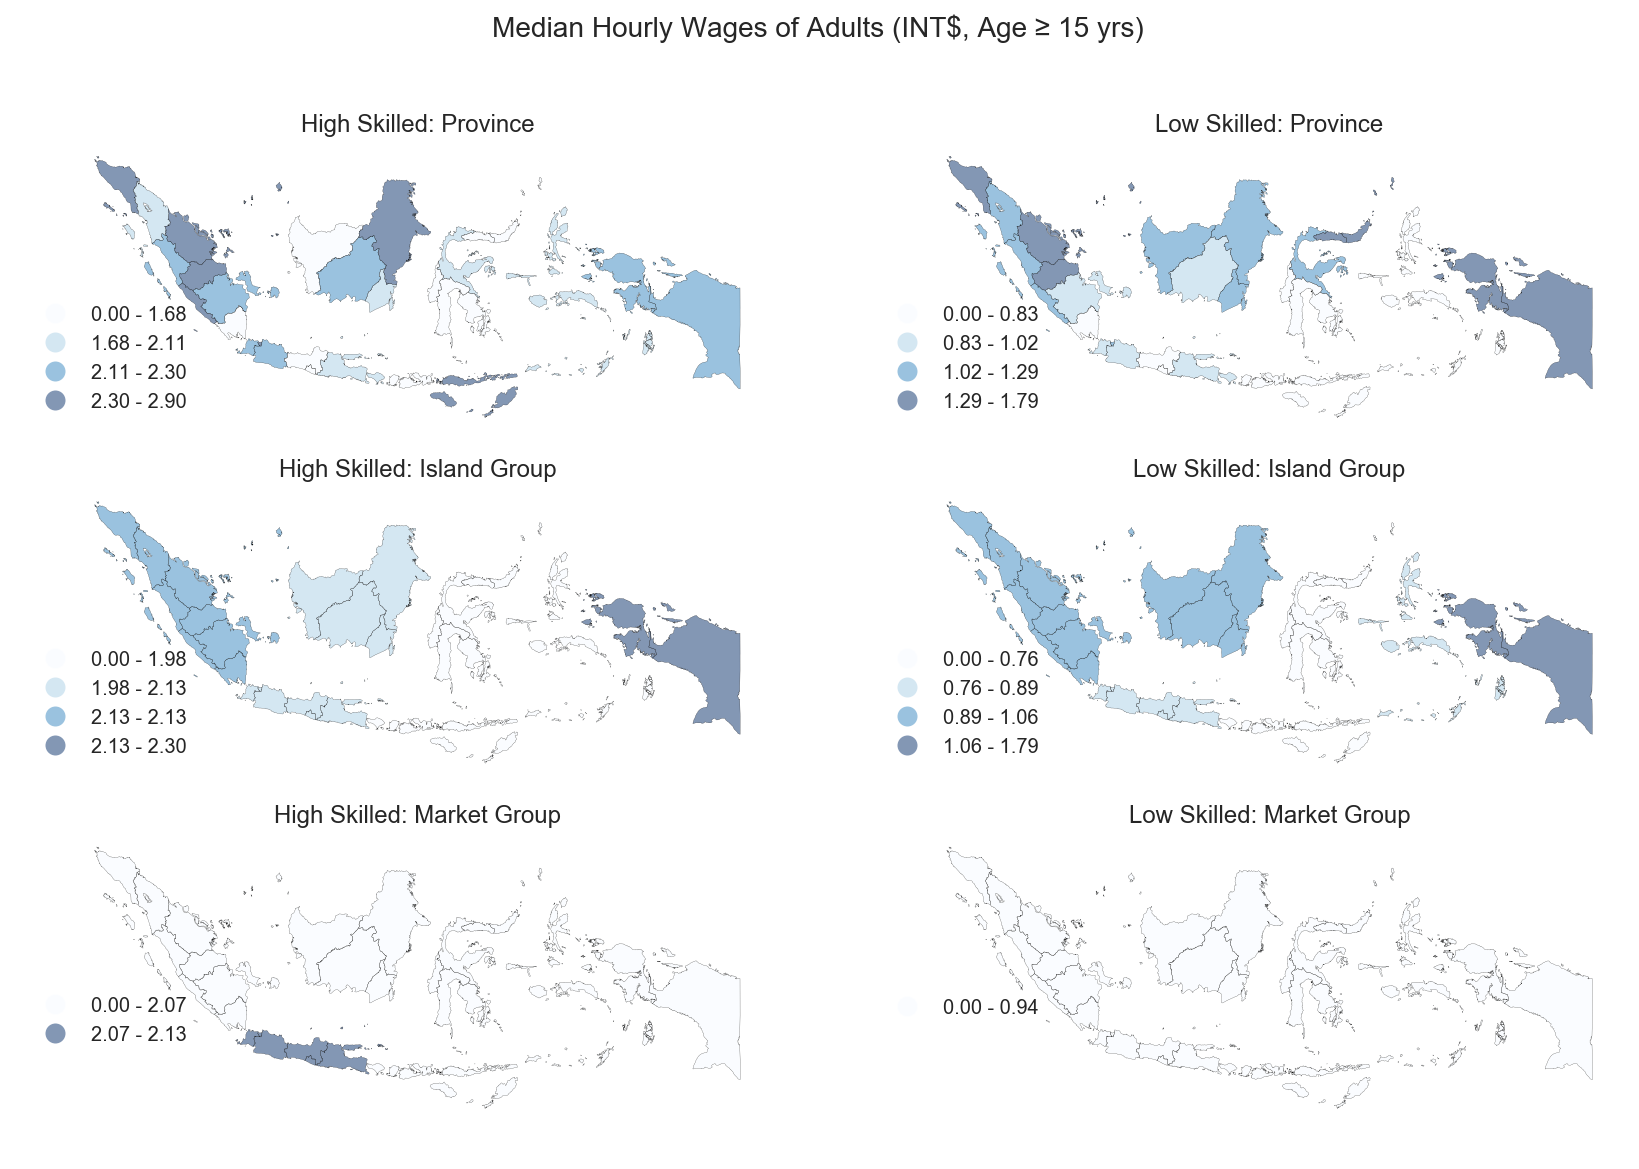

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(14,9))

Base_1 = Ind_Adult_Prov[Ind_Adult_Prov.Skill_Level_School==1]
Base_2 = Ind_Adult_Prov[Ind_Adult_Prov.Skill_Level_School==0]

Base_3 = Ind_Adult_Island[Ind_Adult_Island.Skill_Level_School==1]
Base_4 = Ind_Adult_Island[Ind_Adult_Island.Skill_Level_School==0]

Base_5 = Ind_Adult_Market[Ind_Adult_Market.Skill_Level_School==1]
Base_6 = Ind_Adult_Market[Ind_Adult_Market.Skill_Level_School==0]

Bases = [Base_1, Base_2, Base_3, Base_4, Base_5, Base_6]

LOC = (0., 0.30, 0.2, 0.2)

count = 0

Title1 = ['High Skilled','Low Skilled']
Title2 = ['Province','Island Group','Market Group']

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        
        if count<4: quant=4
        else: quant=2
            
        ( Bases[count].plot(ax=ax[i,j], column="r_wage_hr", cmap='Blues', 
                            scheme="quantiles", k=quant, 
                            linewidth=0.1, legend=True)
                      .axis('off') );
        
        ax[i,j].get_legend().set_bbox_to_anchor(LOC)
        
        ax[i,j].set_title(Title1[j] + ': ' + Title2[i])
        
        count += 1

fig.suptitle('Median Hourly Wages of Adults (INT$, Age ≥ 15 yrs)', fontsize=14);

fig.savefig('/Users/idiosyncrasy58/Desktop/All_Med_Wages.png',
            dpi=500, frameon=False, bbox_inches='tight')

## Wages and Schooling of Children

Find those in child wages with duplicated wages and collapse by person and province

In [25]:
Wages_Child["Dup"] = Wages_Child.duplicated("serial",False).astype('int')

In [26]:
Wages_Child_Coll = Wages_Child[Wages_Child.Dup==1].drop(["Dup","year"],axis=1,inplace=False)
Wages_Child = Wages_Child[Wages_Child.Dup!=1].drop(["Dup","year"],axis=1,inplace=False)

In [27]:
Wages_Child_Coll = Wages_Child_Coll.groupby(["Prov Code","serial"], as_index=False).mean()

In [28]:
Wages_Child = Wages_Child.append(Wages_Child_Coll,ignore_index=True)

In [29]:
del Wages_Child_Coll

Append the Child Wages from Ipums

In [30]:
Wages_Child = Wages_Child.append(Census_Data_Child.loc[:,["serial","r_wage_hr","MaxSchYrs","age","Prov Code"]])
del Census_Data_Child

Create log wages

In [31]:
Wages_Child["ln_wage_hr"] = np.log(Wages_Child["r_wage_hr"])
Wages_Child.drop("r_wage_hr",axis=1,inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


Aggregate variables by Provinces

In [32]:
function={'MaxSchYrs':'mean','age':'mean','ln_wage_hr':'median','serial':'count'}

Avg_Prov_Child = Wages_Child.groupby("Prov Code", as_index=False).agg(function)

Avg_Prov_Child["r_wage_hr"] = np.exp(Avg_Prov_Child.ln_wage_hr)

Drop provinces where there is only one observation of a wage

In [33]:
Avg_Prov_Child = Avg_Prov_Child[Avg_Prov_Child.serial>1].drop(["age","serial","ln_wage_hr"],axis=1,inplace=False)

Merge into the geopandas dataframe

In [34]:
Ind_Child = Ind.merge(Avg_Prov_Child, how='left', on="Prov Code").dropna()

### Plot Child Wages

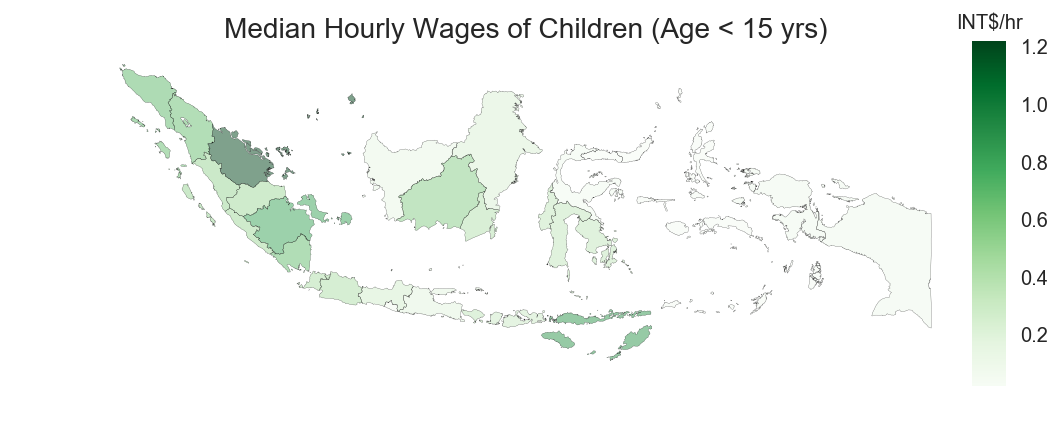

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

vmin, vmax = Ind_Child.r_wage_hr.min(), Ind_Child.r_wage_hr.max()

Ind_Child.plot(ax=ax, column="r_wage_hr", cmap='Greens',linewidth=0.1).axis('off');

plt.title('Median Hourly Wages of Children (Age < 15 yrs)', fontsize=14);

#Color bar for choropleth
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax).ax.set_title('INT$/hr', fontsize=10)

fig.savefig('/Users/idiosyncrasy58/Desktop/Child_Med_Wages.png',
            dpi=500, frameon=False, bbox_inches='tight');

## GRP overlaid on Meidan Provincial Wage

In [36]:
#Create the Connection to SQL database with the Geocodes

conn=sqlite3.connect(path_DB)
Query = 'select name,lat,lon'
Prov_Central_Points = pd.read_sql(Query+',id from Province',conn)
conn.close()

Prov_Central_Points['name'] = Prov_Central_Points['name'].str.decode("utf-8")

Prov_Central_Points["geometry"] = Prov_Central_Points.apply(
                                  lambda row: Point(row["lon"], row["lat"]), axis=1)

Prov_Central_Points.drop(['lat','lon'], axis=1, inplace=True)

In [37]:
# Extract the cartesian coordinates

Prov_Central_Points["x"] = Prov_Central_Points.apply(
                                  lambda row: list(row['geometry'].coords)[0][0], axis=1)
Prov_Central_Points["y"] = Prov_Central_Points.apply(
                                  lambda row: list(row['geometry'].coords)[0][1], axis=1)

In [38]:
#Create the Average wages by province, not according to skill level

Avg_Prov = Wages.groupby(["Prov Code"], as_index=False).agg({'ln_wage_hr':'median'})

Avg_Prov["r_wage_hr"] = np.exp(Avg_Prov.ln_wage_hr)
Avg_Prov.drop("ln_wage_hr",axis=1,inplace=True)

Ind_Prov_Avg = Ind.merge(Avg_Prov, how='left', on="Prov Code")

In [39]:
#Read in the Gross Regional Product
col_keep =['Prov Code','GRP PPP per capita','GRP PPP 2015']
GRP = pd.read_excel(path_GRP, sheetname='Sheet1')[col_keep]
GRP.head()

for col in col_keep[1:]:
    GRP[col] = GRP[col].str.replace('$','').str.replace(',','').astype(float)
    
#Create the aggregate GRP/capita (Collapse by Province Code as the Codes were previously harmonized to 1993 codes)
GRP["GRP PPP 2015"] = GRP["GRP PPP 2015"]*(10**9)
GRP["Population"] = GRP["GRP PPP 2015"]/GRP["GRP PPP per capita"]
GRP = GRP.groupby('Prov Code', as_index=False)['GRP PPP 2015','Population'].sum()
GRP['GRP per capita'] = GRP['GRP PPP 2015']/GRP.Population
GRP.drop(['GRP PPP 2015','Population'],axis=1,inplace=True)

#Merge in the Coordinates of the provinces
GRP = ( GRP.merge(Prov_Central_Points[['id','x','y']], how='left', left_on='Prov Code', right_on='id')
           .drop('id',axis=1,inplace=False) )

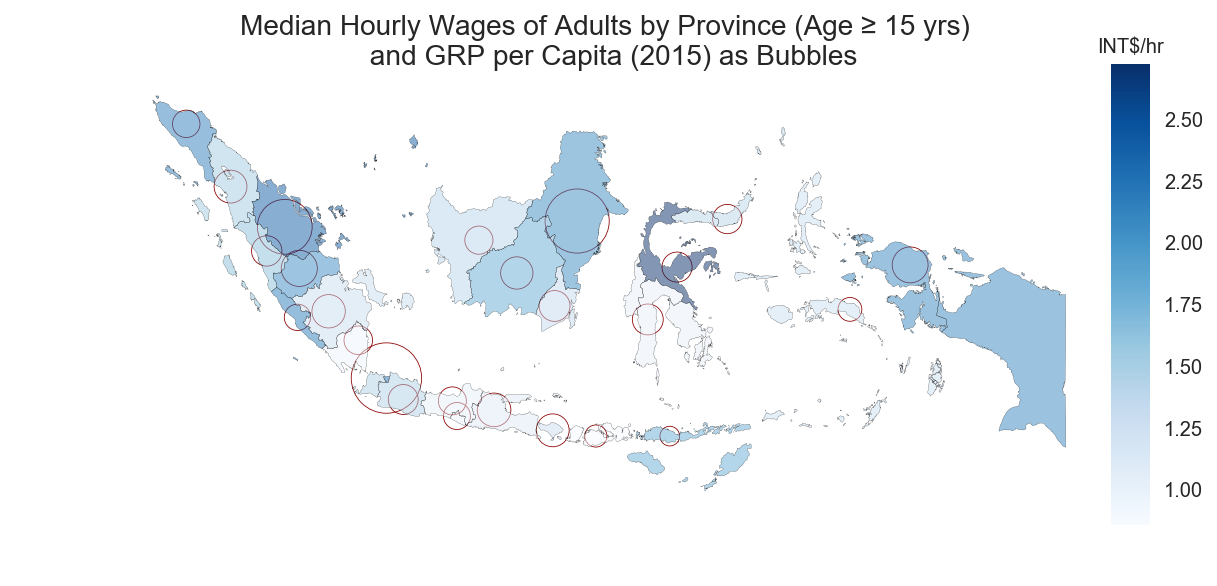

In [40]:
#Plot the GRP as a bubble on top of the map
fig, ax = plt.subplots(1,1,figsize=(9,4));

vmin, vmax = Ind_Prov_Avg.r_wage_hr.min(), Ind_Prov_Avg.r_wage_hr.max()

base_1 = GRP.plot.scatter(x='x',y='y', marker='o', s=GRP['GRP per capita']*0.025, legend=False,
                          ax=ax, color="None", edgecolor='darkred', linewidth=0.4);

Ind_Prov_Avg.plot(column="r_wage_hr", cmap='Blues', linewidth=0.1, ax=base_1);

plt.title('Median Hourly Wages of Adults by Province (Age ≥ 15 yrs) \n and GRP per Capita (2015) as Bubbles', 
          fontsize=14);

plt.axis('off');

#Add colorbar
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, cax=cax).ax.set_title('INT$/hr', fontsize=10)

fig.savefig('/Users/idiosyncrasy58/Desktop/Wages and GRP.png',
            dpi=500, frameon=False, bbox_inches='tight');

### Correlation between Wages and 2015 GRP

In [41]:
Test = Ind_Prov_Avg[["Prov Code","r_wage_hr"]].merge(GRP[["Prov Code","GRP per capita"]],how='left',on="Prov Code")

In [42]:
Test['GRP Rank'] = Test['GRP per capita'].rank(ascending=False)
Test['Wage Rank'] = Test.r_wage_hr.rank(ascending=False)

In [43]:
Test[['GRP Rank','Wage Rank']].corr()

,GRP Rank,Wage Rank
GRP Rank,1.000000,0.406093
Wage Rank,0.406093,1.000000


## Household Location Density Plots

In [44]:
hh_loc = ( pd.read_stata(Path_IFLS+"Temp Files/Counts of Household Locations.dta", convert_categoricals=False)
             .rename(columns={'provmov':'Prov Code','pidlink2':'HH Counts'}) )

In [45]:
HH_Locations = ( Prov_Central_Points.loc[:,["id","x","y"]]
                .merge(hh_loc, how='right', left_on="id",right_on='Prov Code')
                .drop("Prov Code",axis=1, inplace=False) )

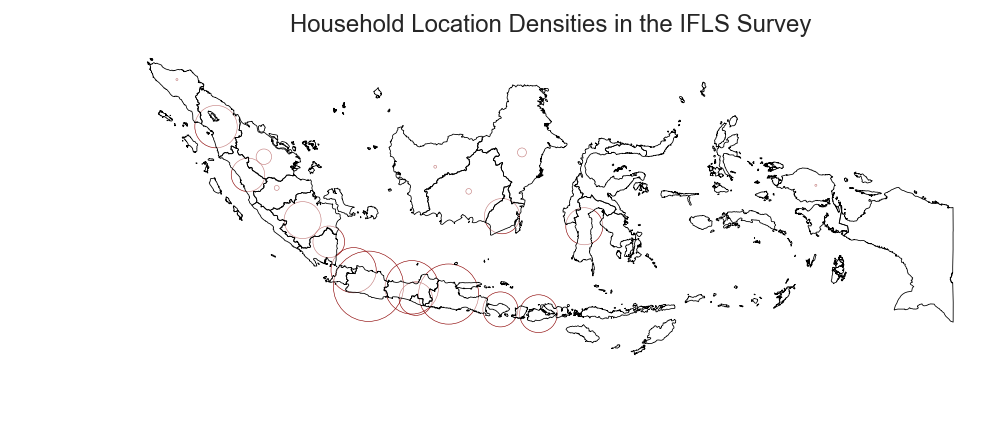

In [46]:
base_1=Ind.plot(color='white', linewidth=0.4, figsize=(8,3))
HH_Locations.plot(x='x',y='y', marker='o', s=HH_Locations['HH Counts'], 
                  kind='scatter', ax=base_1, color="None",
                  edgecolor='darkred');

plt.title('Household Location Densities in the IFLS Survey')

plt.axis('off');

plt.savefig('/Users/idiosyncrasy58/Desktop/HH Locations.png',
            dpi=500, frameon=False, bbox_inches='tight')